Total trainable parameters: 6,485,883
Total trainable parameters: 573,443
max_label, dim: 5 768


100%|██████████| 249/249 [00:07<00:00, 31.41it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.71239895..3.0039248].


tensor([1.4786, 1.2352, 4.0106, 0.3936, 2.6081, 1.1842], device='cuda:0')
tensor([21.7414, 21.9785, 21.4905, 20.7514, 20.7732, 21.0911], device='cuda:0')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.668757..3.091722].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.7719966..3.5869431].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9187496..3.863376].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.98814374..4.268065].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.2926198..5.324717].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.5460933..6.439016].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6359828..7.

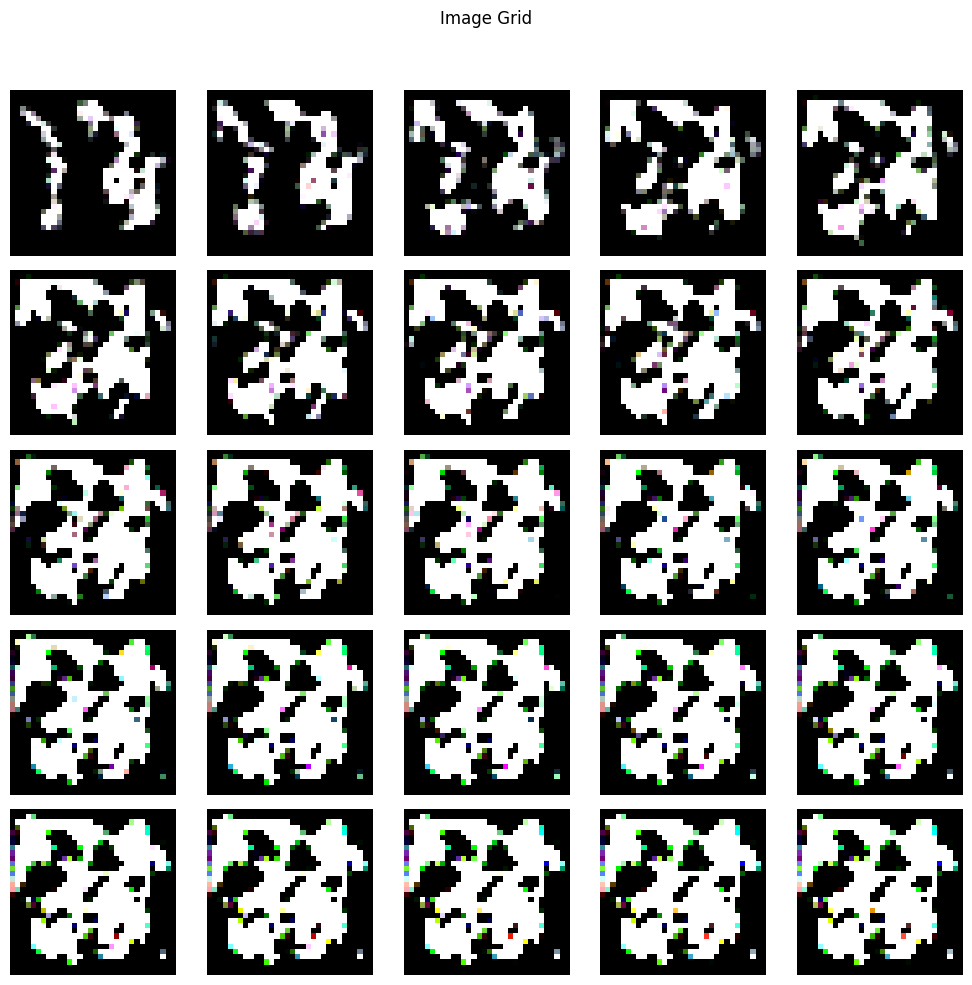

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-6.0060663..40.59976].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-7.578451..46.512856].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-5.5979395..38.26696].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-5.8417096..36.774494].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-7.302879..53.569805].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-5.3972297..38.37962].


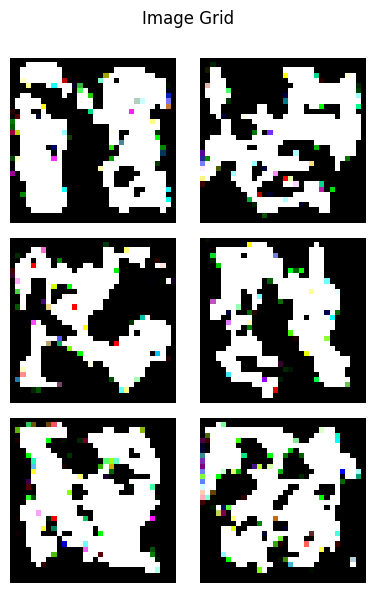

In [13]:
import torch 
from utils import generate_alpha_bar, plot_image_grid, generate_alpha
from models import count_parameters 
import math 
from tqdm import tqdm
from diffusion_config import Timesteps, Beta_0, Beta_T
from guided_unet import get_pos_emb

mym = torch.load("model_collection/np_demo.pth", weights_only=False)
count_parameters(mym)
mym.eval()

dec = torch.load("model_collection/deczmuv.pth", weights_only=False)
count_parameters(dec)
dec.eval()

T = Timesteps
beta_0 = Beta_0
beta_T = Beta_T
a_bar = generate_alpha_bar(beta_0, beta_T, T)
alpha = generate_alpha(beta_0, beta_T, T)

W = 16
max_label, dim = 5, 768
print("max_label, dim:", max_label, dim)
emb_mat = get_pos_emb(torch.tensor(range(max_label+1)), dim).cuda()

batch_size = max_label+1
z_t = torch.randn(batch_size, 3, W, W).cuda()
storage = torch.zeros((T, 3, W, W))

label = torch.tensor(range(max_label+1)).long()
X_att_emb = emb_mat[label]
X_att_emb = X_att_emb.unsqueeze(1).repeat(1,5,1)

guidance_scale = 6
guided = torch.ones(batch_size).cuda()

with torch.no_grad():
    for t in tqdm(range(T-1,0,-1)): 
        time = t * torch.ones(batch_size).cuda()

        z_in = torch.concat([z_t, z_t], dim=0)
        time_in = torch.concat([time, time], dim=0)
        emb_in = torch.concat([X_att_emb, X_att_emb], dim=0)
        guided_in = torch.concat([guided, 0*guided], dim=0)

        noise = mym(z_in, time_in, emb_in, guided_in)
        noise_guided, noise_unguided = noise[:batch_size], noise[batch_size:]
        noise = noise_unguided + guidance_scale * (noise_guided - noise_unguided)

        # PREDICT NEXT TIME STEP 
        # z0_pred = (z_t - math.sqrt(1-a_bar[t]) * noise) / math.sqrt(a_bar[t])
        # z_t = math.sqrt(a_bar[t-1]) * z0_pred + math.sqrt(1-a_bar[t-1]) * noise

        z_t = (1/math.sqrt(alpha[t]))*(z_t - ((1-alpha[t])/(math.sqrt(1-a_bar[t]))) * noise) # + sigma_t * Z
        storage[T-t-1] = z_t[-1].cpu()



print(z_t.mean(dim=(1,2,3)))
print(z_t.std(dim=(1,2,3)))

X_storage = dec(storage.cuda())
plot_image_grid(X_storage[::10])

X_out = dec(z_t)
plot_image_grid(X_out)

